In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Initial setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Soil column properties
zs = 500.0 # Depth of soil [cm]
dz = 15.0   # Numerical model layer thickness [cm]

# Soil properties
Cs = 635.0 # Heat capacity of soil/permafrost [J/(kg K)]
ks = 0.25  # Thermal conductivity of soil/permafrost [W/(m K)]
rhos = 920.0 # Bulk density of permafrost [kg/m^3]

dt = 0.25 # Time step [day]

# Load and Plot the Air Temperature Trends

In [3]:
permafrost = '/content/drive/My Drive/Colab Notebooks/PermafrostTemperatureScenarios.csv'
data = np.loadtxt(permafrost, delimiter=',', skiprows=1)

t_year = data[:,0]
T_15 = data[:,1]
T_30 = data[:,2]
T_45 = data[:,3]

Text(0, 0.5, 'Annual average air temperature [°C]')

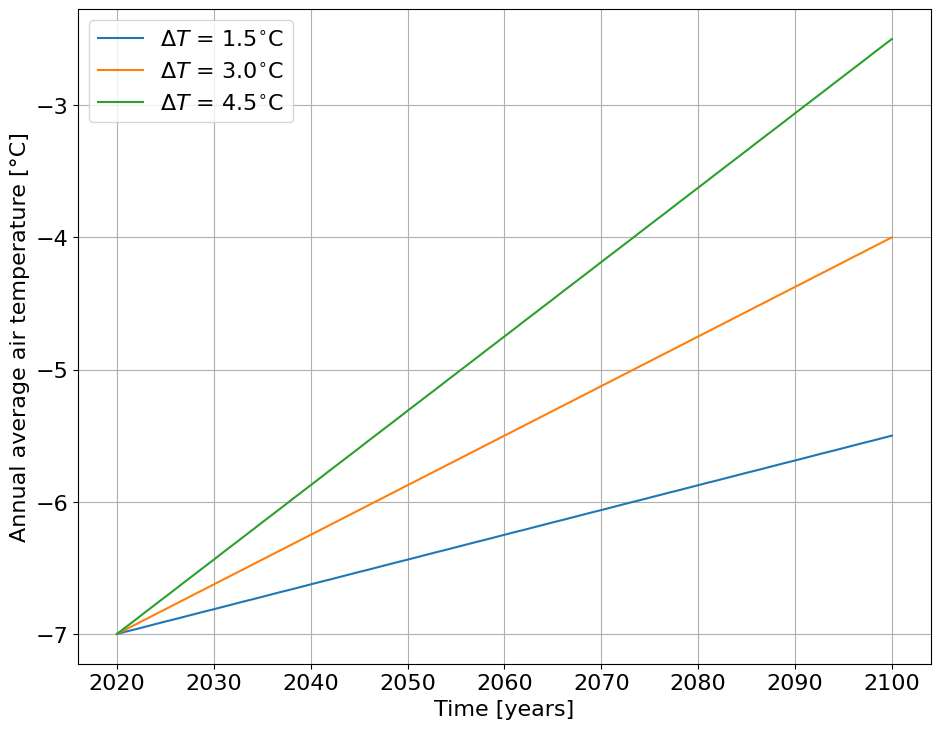

In [4]:
## First off, let's change the font size for all of our plots to be more legible
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(11.0,8.5))
plt.plot(t_year,T_15,label='$\Delta T$ = 1.5${}^{\circ}$C')
plt.plot(t_year,T_30,label='$\Delta T$ = 3.0${}^{\circ}$C')
plt.plot(t_year,T_45,label='$\Delta T$ = 4.5${}^{\circ}$C')
plt.legend(loc='upper left')
plt.grid()
plt.xlabel('Time [years]')
plt.ylabel('Annual average air temperature [°C]')

# Setup the Simulation Time Period

In [5]:
# Time properties of simulation
t0 = t_year[0]
tf = t_year[-1]

t = np.arange(t0,tf+(dt/365),(dt/365))
Nt = t.size
print('The number of time steps: Nt = ',str(Nt))

The number of time steps: Nt =  116801


# Setup Boundary Conditions

In [6]:
# Boundary conditions
Ttopamp = 35.0
Tbottom = -7.0

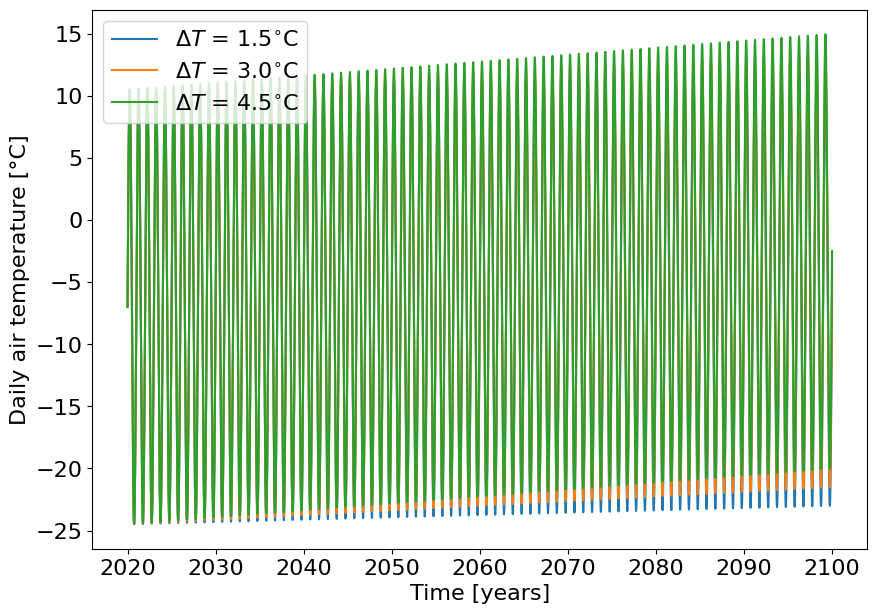

In [7]:
Ttop_15 = np.interp(t, t_year, T_15) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)
Ttop_30 = np.interp(t, t_year, T_30) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)
Ttop_45 = np.interp(t, t_year, T_45) + (Ttopamp/2.0)*np.sin((2.0*np.pi)*t)

plt.figure(figsize=(10.0,7.0))
plt.plot(t, Ttop_15, label='$\Delta T$ = 1.5${}^{\circ}$C')
plt.plot(t, Ttop_30, label='$\Delta T$ = 3.0${}^{\circ}$C')
plt.plot(t, Ttop_45, label='$\Delta T$ = 4.5${}^{\circ}$C')
plt.xlabel('Time [years]')
plt.ylabel('Daily air temperature [°C]')
plt.legend(loc='upper left')
plt.show()

# Setup Spatial Domain

In [8]:
z = np.arange(dz/2, zs, dz)
Nz = z.size
print('Here are the locations of our cells: z = \n' + str(z))
print('The number of cells is: Nz = ',str(Nz))

Here are the locations of our cells: z = 
[  7.5  22.5  37.5  52.5  67.5  82.5  97.5 112.5 127.5 142.5 157.5 172.5
 187.5 202.5 217.5 232.5 247.5 262.5 277.5 292.5 307.5 322.5 337.5 352.5
 367.5 382.5 397.5 412.5 427.5 442.5 457.5 472.5 487.5]
The number of cells is: Nz =  33


# Calculate the Soil Diffusivity and Diffusion Number

In [9]:
# Calculate diffusivity of permafrost soil
Ds = ks / (rhos * Cs)
print('Soil diffusivity = '+str(Ds)+' m^2/s')

# Convert alpha to units consistent with domain [cm^2/day]
Ds = Ds*(100.0**2)*(24.0*3600.0)
print('Soil diffusivity = '+str(Ds)+' cm^2/day')

alpha = Ds*dt/(2.0*dz**2) #Note division by 2.0
print('Diffusion number '+str(alpha))

Soil diffusivity = 4.279356384799726e-07 m^2/s
Soil diffusivity = 369.7363916466963 cm^2/day
Diffusion number 0.20540910647038682


# Calculate *D*, **B**, and **A** Matrices for Implicit or Crank-Nicolson Method

In [10]:
# Matrix A
A = np.diag((1 + 2.0*alpha)*np.ones((Nz))) + \
    np.diag(-alpha*np.ones((Nz-1)),1) + \
    np.diag(-alpha*np.ones((Nz-1)),-1)

A[0,:] = np.hstack((1.0,np.zeros((Nz-1))))
A[-1,:] = np.hstack((np.zeros((Nz-1)),1.0))

# Matrix B
B = np.diag((1 - 2.0*alpha)*np.ones((Nz))) + \
    np.diag(alpha*np.ones((Nz-1)),1) + \
    np.diag(alpha*np.ones((Nz-1)),-1)

B[0,:] = np.hstack((1.0,np.zeros((Nz-1))))
B[-1,:] = np.hstack((np.zeros((Nz-1)),1.0))


# Setup Boundary and Initial Conditions

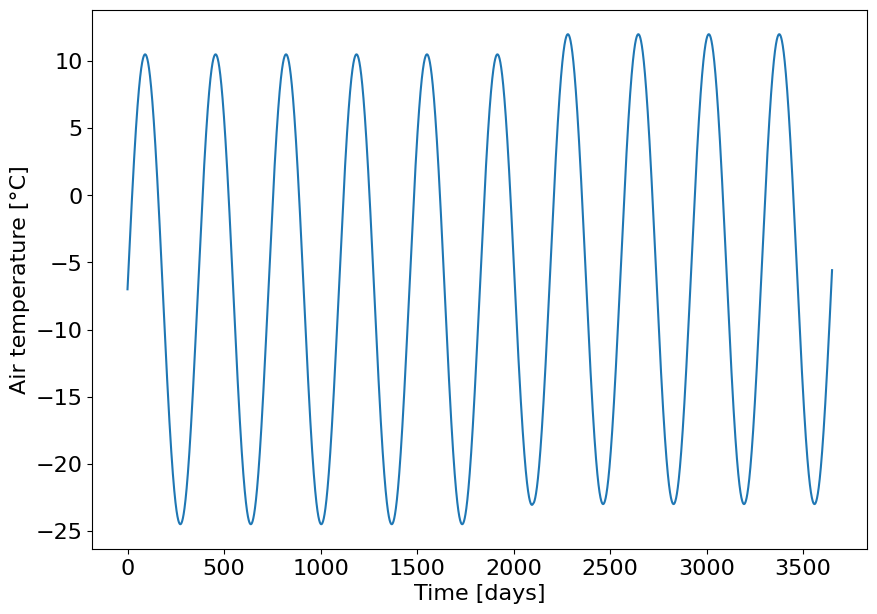

In [11]:
t_spinup = np.arange(0,10*365,dt)

Nt_spinup = t_spinup.size

Ttopbase = np.interp(t_spinup, t_year, T_15)

Ttop = Ttopbase + (Ttopamp/2.0)*np.sin((2.0*np.pi/(365.0))*t_spinup)

plt.figure(figsize=(10.0,7.0))
plt.plot(t_spinup,Ttop)
plt.xlabel('Time [days]')
plt.ylabel('Air temperature [°C]')

Ts0 = Tbottom*np.ones((Nz,1))

In [12]:
print(Ttop.shape)

(14600,)


# Preallocate Storage for Soil Temperatures

In [13]:
Ts = np.zeros((Nz,Nt))

# Apply Solution And Compute Temperatures

In [27]:
# Initialize arrays to store the results for each scenario
Ts_15C = np.zeros((Nz, Nt))  # For ΔT = 1.5°C
Ts_30C = np.zeros((Nz, Nt))  # For ΔT = 3.0°C
Ts_45C = np.zeros((Nz, Nt))  # For ΔT = 4.5°C

# Loop for each scenario

# For ΔT = 1.5°C scenario
for i in np.arange(min(Nt, Ttop_15.shape[0])):  # Ttop_15 is the boundary condition for ΔT = 1.5°C
    if i == 0:
        Tsi = Ts0  # Initial condition
    else:
        Tsi = Ts_15C[:, i - 1]
        Tsi[0] = Ttop_15[i]  # Set the top boundary condition
        Tsi[-1] = Tbottom  # Set the bottom boundary condition

    # Solve for the next time step
    Tsip1 = np.matmul(np.matmul(np.linalg.pinv(A), B), Tsi)
    Ts_15C[:, i] = np.squeeze(Tsip1)

# For ΔT = 3.0°C scenario
for i in np.arange(min(Nt, Ttop_30.shape[0])):  # Ttop_30 is the boundary condition for ΔT = 3.0°C
    if i == 0:
        Tsi = Ts0  # Initial condition
    else:
        Tsi = Ts_30C[:, i - 1]
        Tsi[0] = Ttop_30[i]  # Set the top boundary condition
        Tsi[-1] = Tbottom  # Set the bottom boundary condition

    # Solve for the next time step
    Tsip1 = np.matmul(np.matmul(np.linalg.pinv(A), B), Tsi)
    Ts_30C[:, i] = np.squeeze(Tsip1)

# For ΔT = 4.5°C scenario
for i in np.arange(min(Nt, Ttop_45.shape[0])):  # Ttop_45 is the boundary condition for ΔT = 4.5°C
    if i == 0:
        Tsi = Ts0  # Initial condition
    else:
        Tsi = Ts_45C[:, i - 1]
        Tsi[0] = Ttop_45[i]  # Set the top boundary condition
        Tsi[-1] = Tbottom  # Set the bottom boundary condition

    # Solve for the next time step
    Tsip1 = np.matmul(np.matmul(np.linalg.pinv(A), B), Tsi)
    Ts_45C[:, i] = np.squeeze(Tsip1)


# Plot Results, Analyze, and Interpret

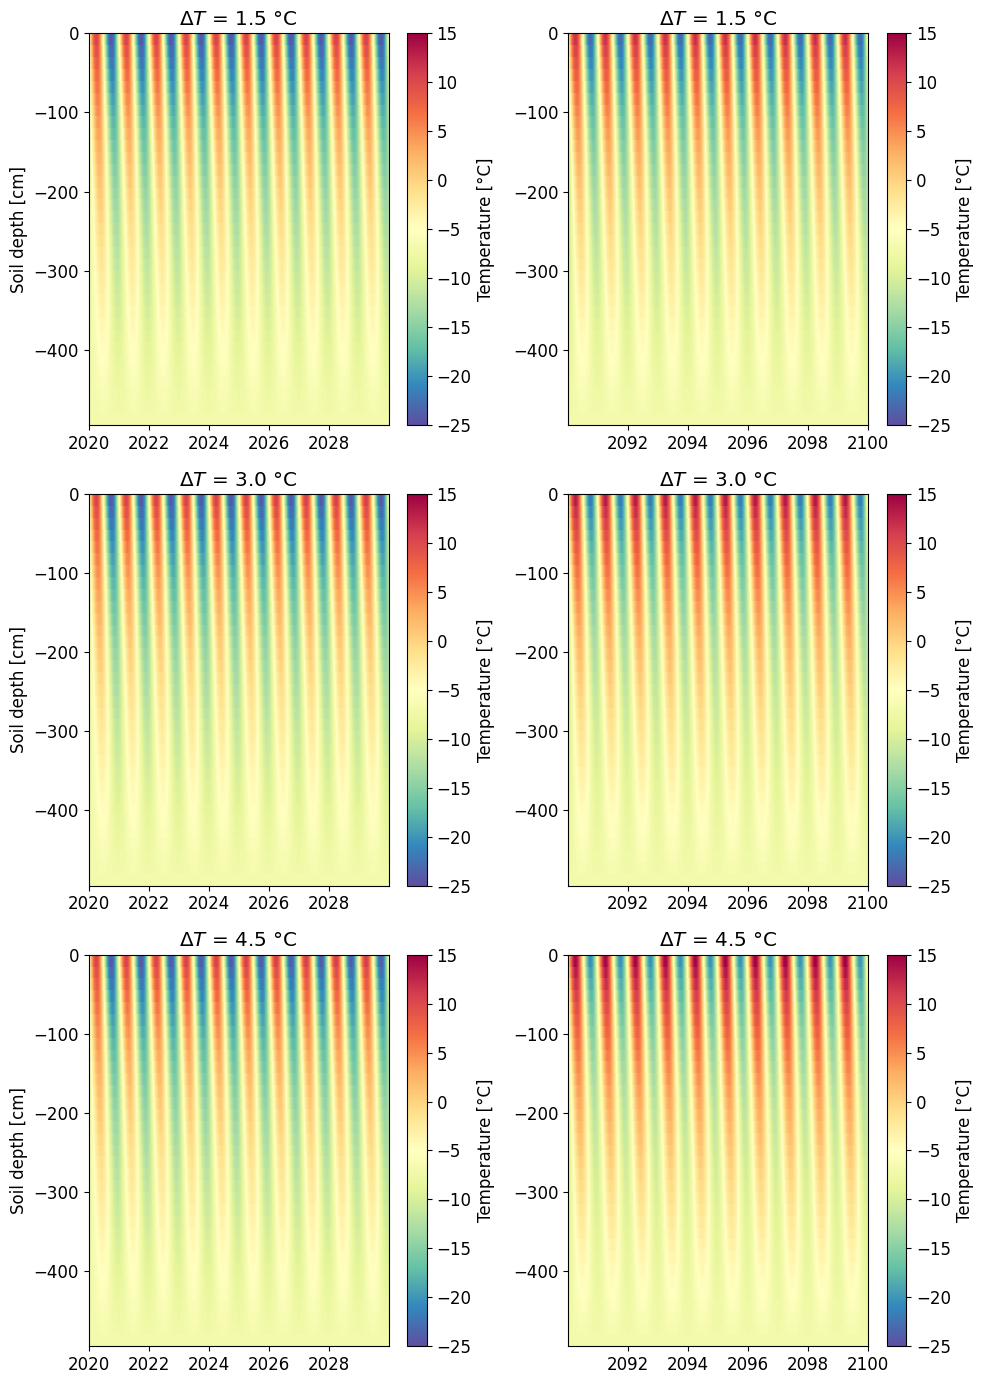

In [28]:
# Create the figure with subplots
plt.figure(figsize=(10.0, 14.0))

# ΔT = 1.5 °C simulation
plt.subplot(3, 2, 1)
plt.title('$\Delta T$ = 1.5 °C')
plt.pcolormesh(tt[:, :npoints_decade], -zz[:, :npoints_decade], Ts_15C[:, :npoints_decade], cmap='Spectral_r', vmin=-25, vmax=15)
plt.ylabel('Soil depth [cm]')
plt.colorbar(label='Temperature [°C]')

# Last 10 years
plt.subplot(3, 2, 2)
plt.title('$\Delta T$ = 1.5 °C')
plt.pcolormesh(tt[:, -npoints_decade:], -zz[:, -npoints_decade:], Ts_15C[:, -npoints_decade:], cmap='Spectral_r', vmin=-25, vmax=15)
plt.colorbar(label='Temperature [°C]')

# ΔT = 3.0 °C simulation
plt.subplot(3, 2, 3)
plt.title('$\Delta T$ = 3.0 °C')
plt.pcolormesh(tt[:, :npoints_decade], -zz[:, :npoints_decade], Ts_30C[:, :npoints_decade], cmap='Spectral_r', vmin=-25, vmax=15)
plt.ylabel('Soil depth [cm]')
plt.colorbar(label='Temperature [°C]')

# Last 10 years
plt.subplot(3, 2, 4)
plt.title('$\Delta T$ = 3.0 °C')
plt.pcolormesh(tt[:, -npoints_decade:], -zz[:, -npoints_decade:], Ts_30C[:, -npoints_decade:], cmap='Spectral_r', vmin=-25, vmax=15)
plt.colorbar(label='Temperature [°C]')

# ΔT = 4.5 °C simulation
plt.subplot(3, 2, 5)
plt.title('$\Delta T$ = 4.5 °C')
plt.pcolormesh(tt[:, :npoints_decade], -zz[:, :npoints_decade], Ts_45C[:, :npoints_decade], cmap='Spectral_r', vmin=-25, vmax=15)
plt.ylabel('Soil depth [cm]')
plt.colorbar(label='Temperature [°C]')

# Last 10 years
plt.subplot(3, 2, 6)
plt.title('$\Delta T$ = 4.5 °C')
plt.pcolormesh(tt[:, -npoints_decade:], -zz[:, -npoints_decade:], Ts_45C[:, -npoints_decade:], cmap='Spectral_r', vmin=-25, vmax=15)
plt.colorbar(label='Temperature [°C]')

# Show the plots
plt.tight_layout()
plt.show()


<ipython-input-31-af053fbbf631>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  current_cmap = plt.cm.get_cmap('Spectral_r')


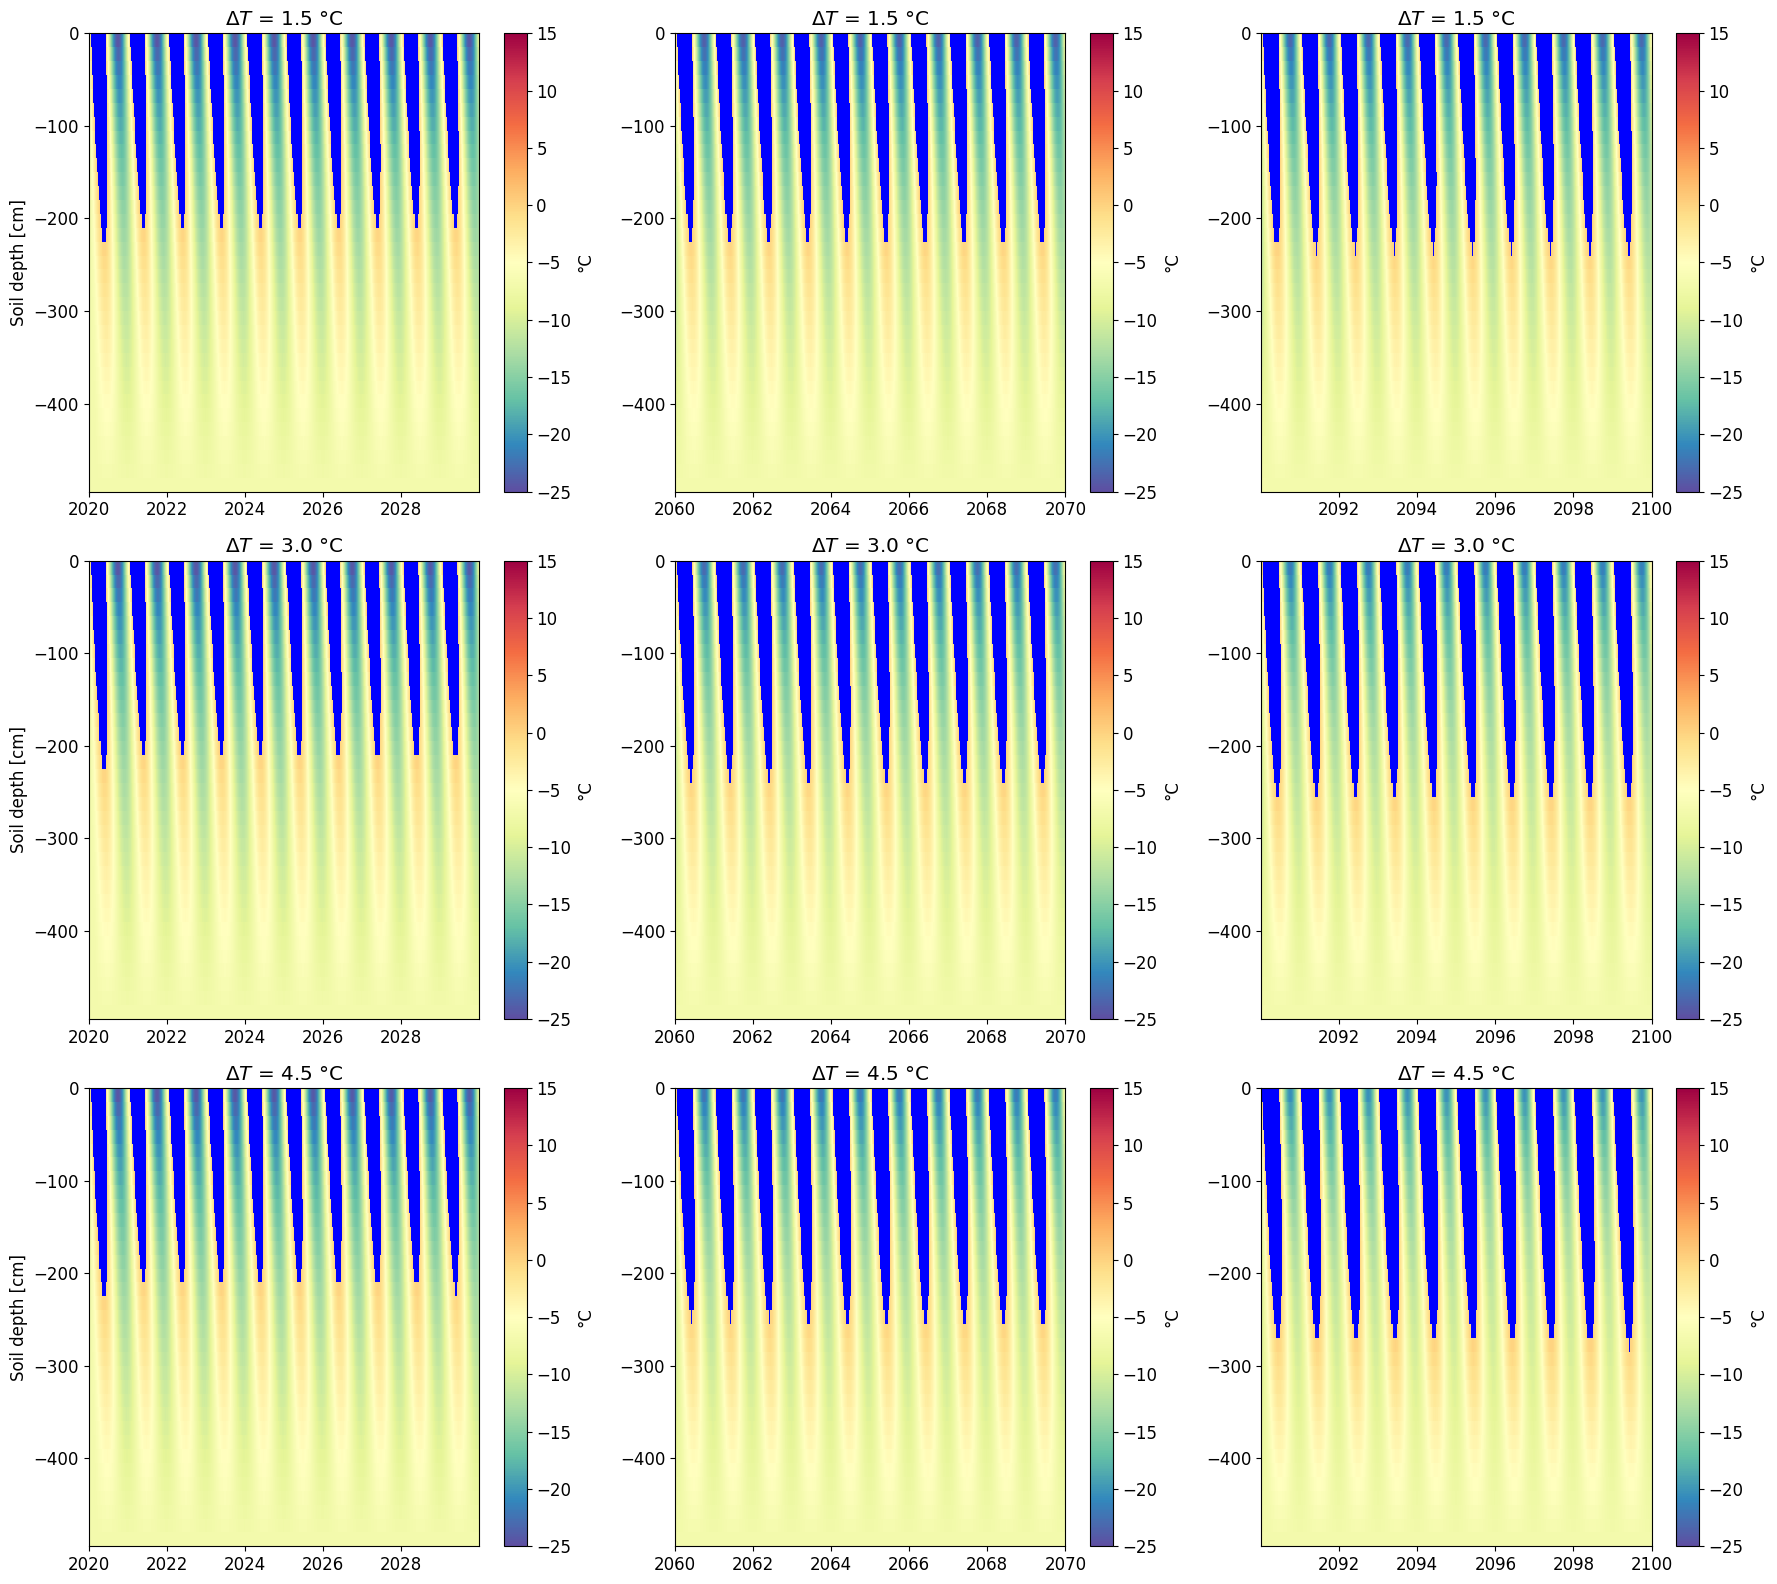

In [31]:
# Mask temperatures above 0°C to only show frozen temperatures
Ts_15C_frozen = np.ma.masked_where(Ts_15C > 0.0, Ts_15C)
Ts_30C_frozen = np.ma.masked_where(Ts_30C > 0.0, Ts_30C)
Ts_45C_frozen = np.ma.masked_where(Ts_45C > 0.0, Ts_45C)

# Set up the colormap and handle masked values (above freezing) as blue
current_cmap = plt.cm.get_cmap('Spectral_r')
current_cmap.set_bad(color='blue')

# Create the figure and set size
plt.figure(figsize=(18.0, 16.0))

# 1.5 °C simulation
plt.subplot(3, 3, 1)
plt.title('$\Delta T$ = 1.5 °C')
plt.pcolormesh(tt[:, :npoints_decade], -zz[:, :npoints_decade], Ts_15C_frozen[:, :npoints_decade], cmap=current_cmap, vmin=-25, vmax=15)
plt.ylabel('Soil depth [cm]')
plt.colorbar(label='°C')

plt.subplot(3, 3, 2)
plt.title('$\Delta T$ = 1.5 °C')
plt.pcolormesh(tt[:, mid_cent_start:mid_cent_end], -zz[:, mid_cent_start:mid_cent_end], Ts_15C_frozen[:, mid_cent_start:mid_cent_end], cmap=current_cmap, vmin=-25, vmax=15)
plt.colorbar(label='°C')

plt.subplot(3, 3, 3)
plt.title('$\Delta T$ = 1.5 °C')
plt.pcolormesh(tt[:, -npoints_decade:], -zz[:, -npoints_decade:], Ts_15C_frozen[:, -npoints_decade:], cmap=current_cmap, vmin=-25, vmax=15)
plt.colorbar(label='°C')

# 3.0 °C simulation
plt.subplot(3, 3, 4)
plt.title('$\Delta T$ = 3.0 °C')
plt.pcolormesh(tt[:, :npoints_decade], -zz[:, :npoints_decade], Ts_30C_frozen[:, :npoints_decade], cmap=current_cmap, vmin=-25, vmax=15)
plt.ylabel('Soil depth [cm]')
plt.colorbar(label='°C')

plt.subplot(3, 3, 5)
plt.title('$\Delta T$ = 3.0 °C')
plt.pcolormesh(tt[:, mid_cent_start:mid_cent_end], -zz[:, mid_cent_start:mid_cent_end], Ts_30C_frozen[:, mid_cent_start:mid_cent_end], cmap=current_cmap, vmin=-25, vmax=15)
plt.colorbar(label='°C')

plt.subplot(3, 3, 6)
plt.title('$\Delta T$ = 3.0 °C')
plt.pcolormesh(tt[:, -npoints_decade:], -zz[:, -npoints_decade:], Ts_30C_frozen[:, -npoints_decade:], cmap=current_cmap, vmin=-25, vmax=15)
plt.colorbar(label='°C')

# 4.5 °C simulation
plt.subplot(3, 3, 7)
plt.title('$\Delta T$ = 4.5 °C')
plt.pcolormesh(tt[:, :npoints_decade], -zz[:, :npoints_decade], Ts_45C_frozen[:, :npoints_decade], cmap=current_cmap, vmin=-25, vmax=15)
plt.ylabel('Soil depth [cm]')
plt.colorbar(label='°C')

plt.subplot(3, 3, 8)
plt.title('$\Delta T$ = 4.5 °C')
plt.pcolormesh(tt[:, mid_cent_start:mid_cent_end], -zz[:, mid_cent_start:mid_cent_end], Ts_45C_frozen[:, mid_cent_start:mid_cent_end], cmap=current_cmap, vmin=-25, vmax=15)
plt.colorbar(label='°C')

plt.subplot(3, 3, 9)
plt.title('$\Delta T$ = 4.5 °C')
plt.pcolormesh(tt[:, -npoints_decade:], -zz[:, -npoints_decade:], Ts_45C_frozen[:, -npoints_decade:], cmap=current_cmap, vmin=-25, vmax=15)
plt.colorbar(label='°C')

# Show the plot
plt.tight_layout()
plt.show()


In [32]:
# Helper function to find the depth of the active layer (where temperature crosses 0°C)
def active_layer_depth(Ts, z, time_range):
    # Initialize a list to store active layer depths
    depths = []
    # Loop over the time range and find the depth where temperature crosses 0°C
    for t in time_range:
        # Get the temperature profile at this time step
        temp_profile = Ts[:, t]
        # Find the depth index where the temperature is closest to 0°C
        depth_index = np.where(temp_profile > 0)[0]
        if len(depth_index) > 0:
            depths.append(z[depth_index[0]])  # Get the corresponding depth
        else:
            depths.append(z[-1])  # If no thawed layer, return the deepest depth
    return np.mean(depths)  # Return the average depth over the time range

# Calculate the depth of the active layer for each scenario and time period
first_decade_range = np.arange(0, npoints_decade)
mid_century_range = np.arange(mid_cent_start, mid_cent_end)
last_decade_range = np.arange(-npoints_decade, 0)

# First Decade
depth_15C_first = active_layer_depth(Ts_15C, z, first_decade_range)
depth_30C_first = active_layer_depth(Ts_30C, z, first_decade_range)
depth_45C_first = active_layer_depth(Ts_45C, z, first_decade_range)

# Middle Century
depth_15C_middle = active_layer_depth(Ts_15C, z, mid_century_range)
depth_30C_middle = active_layer_depth(Ts_30C, z, mid_century_range)
depth_45C_middle = active_layer_depth(Ts_45C, z, mid_century_range)

# Last Decade
depth_15C_last = active_layer_depth(Ts_15C, z, last_decade_range)
depth_30C_last = active_layer_depth(Ts_30C, z, last_decade_range)
depth_45C_last = active_layer_depth(Ts_45C, z, last_decade_range)

# Create a markdown table
markdown_table = f"""
| Scenario  | First Decade Depth (cm) | Middle Century Depth (cm) | Last Decade Depth (cm) |
|-----------|-------------------------|---------------------------|------------------------|
| ΔT = 1.5°C| {depth_15C_first:.2f}                  | {depth_15C_middle:.2f}                    | {depth_15C_last:.2f}                |
| ΔT = 3.0°C| {depth_30C_first:.2f}                  | {depth_30C_middle:.2f}                    | {depth_30C_last:.2f}                |
| ΔT = 4.5°C| {depth_45C_first:.2f}                  | {depth_45C_middle:.2f}                    | {depth_45C_last:.2f}                |
"""

# Output the markdown table
print(markdown_table)



| Scenario  | First Decade Depth (cm) | Middle Century Depth (cm) | Last Decade Depth (cm) |
|-----------|-------------------------|---------------------------|------------------------|
| ΔT = 1.5°C| 293.75                  | 284.76                    | 277.96                |
| ΔT = 3.0°C| 292.62                  | 274.71                    | 261.55                |
| ΔT = 4.5°C| 291.49                  | 264.87                    | 245.70                |

